In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [4]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [5]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986177 entries, 0 to 1986176
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 30.3 MB


In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1986172    0.14
1986173    0.14
1986174    0.14
1986175    0.13
1986176    0.13
Name: kWh, Length: 1986177, dtype: float64

In [7]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1986172    0.14
1986173    0.14
1986174    0.14
1986175    0.13
1986176    0.13
Name: kWh, Length: 1986177, dtype: float64

In [8]:
l=len(conso_data)-1
l

1986176

### conversion Interval -> kWh

In [9]:
conso_data['sec']=conso_data['Interval']/1000


In [10]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [11]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [12]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986177 entries, 0 to 1986176
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 75.8 MB


In [13]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1986172,26288,0.14,26.288,136.944614,48614142015
1986173,26365,0.14,26.365,136.544661,48614168380
1986174,26607,0.14,26.607,135.302740,48614194987
1986175,27135,0.13,27.135,132.669983,48614222122
1986176,26807,0.13,26.807,134.293282,48614248929


In [14]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

48614248929000

### Calcul de la date de base = now - cumul_interval

In [15]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 26, 11, 669627)

In [16]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [17]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [18]:
base

datetime.datetime(2023, 8, 21, 21, 26, 11, 669627)

## créer les dates

In [19]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:26:33.603627
1         2023-08-21 21:26:55.461627
2         2023-08-21 21:27:17.462627
3         2023-08-21 21:27:39.390627
4         2023-08-21 21:28:01.281627
                     ...            
1986172   2025-03-06 13:21:53.684627
1986173   2025-03-06 13:22:20.049627
1986174   2025-03-06 13:22:46.656627
1986175   2025-03-06 13:23:13.791627
1986176   2025-03-06 13:23:40.598627
Name: dates, Length: 1986177, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [20]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:26:33.603627,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:26:55.461627,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:27:17.462627,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:27:39.390627,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:28:01.281627,21/08/23
...,...,...,...,...,...,...,...
1986172,26288,0.14,26.288,136.944614,48614142015,2025-03-06 13:21:53.684627,06/03/25
1986173,26365,0.14,26.365,136.544661,48614168380,2025-03-06 13:22:20.049627,06/03/25
1986174,26607,0.14,26.607,135.302740,48614194987,2025-03-06 13:22:46.656627,06/03/25
1986175,27135,0.13,27.135,132.669983,48614222122,2025-03-06 13:23:13.791627,06/03/25


### save conso_data with dates

In [21]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [22]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('06/03/25', 6, 3, 2025)

In [23]:
here = now.strftime('%H:%M:%S')
here

'13:24:15'

In [24]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [25]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 1983978 to 1986176
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2199 non-null   int64         
 1   kWh        2199 non-null   float64       
 2   sec        2199 non-null   float64       
 3   Wh         2199 non-null   float64       
 4   cumul(ms)  2199 non-null   int64         
 5   dates      2199 non-null   datetime64[ns]
 6   days       2199 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 137.4+ KB


### grouped by days

In [26]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [27]:
data = list(df_grp['kWh'])
print(data)

[0.535, 3.691, 4.238, 3.687, 3.925, 4.586, 3.756, 3.464, 3.505, 3.701, 3.379, 4.19, 4.196, 3.697, 3.631, 3.632, 3.315, 3.384, 4.058, 4.019, 4.0, 4.127, 3.514, 4.211, 3.997, 3.746, 4.081, 4.605, 4.173, 3.222, 3.17, 3.865, 3.81, 3.073, 3.783, 4.13, 3.646, 3.733, 4.553, 4.326, 4.413, 3.899, 3.445, 4.27, 3.932, 3.746, 3.565, 3.936, 3.768, 3.47, 4.089, 3.413, 3.824, 3.887, 3.596, 3.725, 4.339, 3.248, 3.878, 3.178, 2.055, 2.05, 2.27, 4.092, 3.629, 4.308, 3.628, 3.989, 3.787, 3.693, 4.18, 3.985, 3.809, 3.141, 3.743, 3.592, 3.549, 3.682, 3.705, 3.34, 3.803, 3.257, 3.757, 3.585, 4.07, 3.573, 3.55, 3.661, 4.043, 4.403, 3.929, 4.062, 4.342, 3.837, 3.862, 3.823, 3.79, 3.827, 4.073, 4.421, 3.87, 3.499, 3.68, 3.683, 3.344, 3.835, 3.795, 4.309, 3.527, 4.163, 3.539, 3.932, 4.697, 3.581, 3.603, 3.516, 3.942, 3.89, 4.146, 3.857, 3.829, 3.632, 4.994, 3.826, 3.677, 4.211, 4.262, 4.323, 4.546, 4.148, 3.662, 4.461, 4.704, 4.088, 4.741, 4.514, 3.663, 4.032, 3.925, 3.618, 3.565, 3.956, 3.656, 3.718, 3.63, 3.4

In [28]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

### plot function by day
#### show('dd/mm/yy')

In [29]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


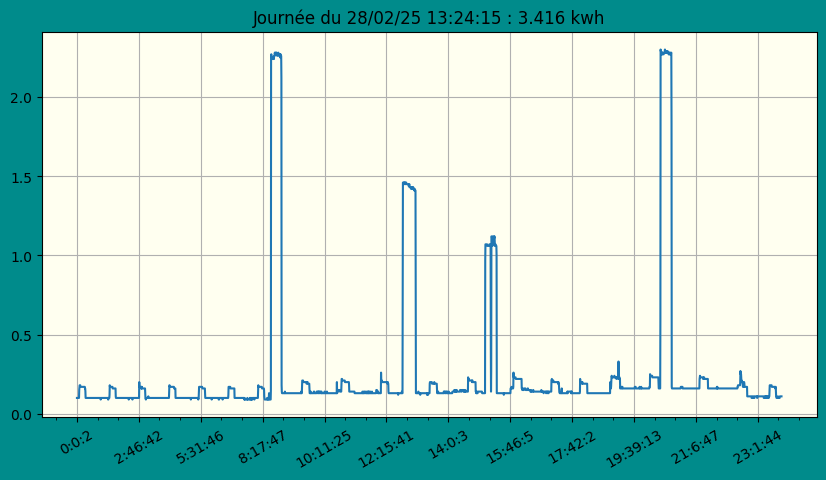

In [30]:
show('28/02/25')

### 1 kWh window in data of one day
#### df = conso_day

In [31]:
df = conso_day

In [32]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [33]:
df = conso_day
len(df)

2199

In [34]:
period()  # first kWh

2025-03-06 00:00:14.323627	2025-03-06 08:10:08.861627	8h 9m 54s 	1000


In [35]:
period(p=2) # second period

2025-03-06 08:10:08.861627	2025-03-06 12:27:34.120627	4h 17m 25s 	2000


In [36]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301287
dtype: float64

### mean for data grouped by days

In [37]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.52159
dtype: float64

In [38]:
last=df_grp.iloc[-1]['kWh']
last

2.199

In [39]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 1983978 to 1986176
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2199 non-null   int64         
 1   kWh        2199 non-null   float64       
 2   sec        2199 non-null   float64       
 3   Wh         2199 non-null   float64       
 4   cumul(ms)  2199 non-null   int64         
 5   dates      2199 non-null   datetime64[ns]
 6   days       2199 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 137.4+ KB


# conso by date


In [40]:
# select day
day = today

#day = '16/08/24'
day

'06/03/25'

In [41]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
1983978,26692,0.13,26.692,134.871872,48566042654,2025-03-06 00:00:14.323627,06/03/25
1983979,26221,0.14,26.221,137.294535,48566068875,2025-03-06 00:00:40.544627,06/03/25
1983980,24336,0.15,24.336,147.928994,48566093211,2025-03-06 00:01:04.880627,06/03/25
1983981,24267,0.15,24.267,148.349611,48566117478,2025-03-06 00:01:29.147627,06/03/25
1983982,24287,0.15,24.287,148.227447,48566141765,2025-03-06 00:01:53.434627,06/03/25
...,...,...,...,...,...,...,...
1986172,26288,0.14,26.288,136.944614,48614142015,2025-03-06 13:21:53.684627,06/03/25
1986173,26365,0.14,26.365,136.544661,48614168380,2025-03-06 13:22:20.049627,06/03/25
1986174,26607,0.14,26.607,135.302740,48614194987,2025-03-06 13:22:46.656627,06/03/25
1986175,27135,0.13,27.135,132.669983,48614222122,2025-03-06 13:23:13.791627,06/03/25


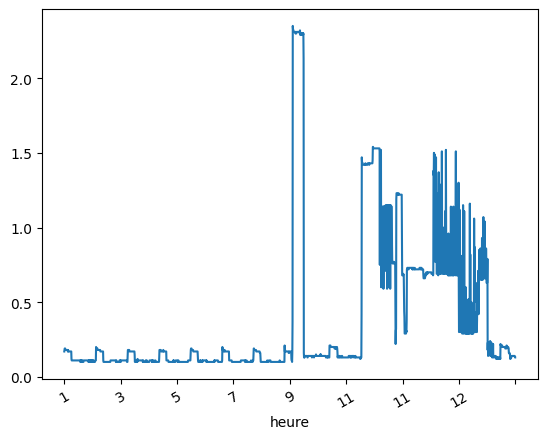

In [42]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


### grouped by 'heure'

In [43]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 1983978 to 1986176
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2199 non-null   int64         
 1   kWh        2199 non-null   float64       
 2   sec        2199 non-null   float64       
 3   Wh         2199 non-null   float64       
 4   cumul(ms)  2199 non-null   int64         
 5   dates      2199 non-null   datetime64[ns]
 6   days       2199 non-null   object        
 7   heure      2199 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 154.6+ KB


In [44]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,26692,0.13,26.692,134.871872,48566042654,2025-03-06 00:00:14.323627,06/03/25
0,26221,0.14,26.221,137.294535,48566068875,2025-03-06 00:00:40.544627,06/03/25
0,24336,0.15,24.336,147.928994,48566093211,2025-03-06 00:01:04.880627,06/03/25
0,24267,0.15,24.267,148.349611,48566117478,2025-03-06 00:01:29.147627,06/03/25
0,24287,0.15,24.287,148.227447,48566141765,2025-03-06 00:01:53.434627,06/03/25
...,...,...,...,...,...,...,...
13,26288,0.14,26.288,136.944614,48614142015,2025-03-06 13:21:53.684627,06/03/25
13,26365,0.14,26.365,136.544661,48614168380,2025-03-06 13:22:20.049627,06/03/25
13,26607,0.14,26.607,135.302740,48614194987,2025-03-06 13:22:46.656627,06/03/25


In [45]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [46]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     152
1     132
2     119
3     119
4     113
5     111
6     118
7     117
8     117
9     163
10    149
11    302
12    420
13     67
Name: kWh, dtype: int64

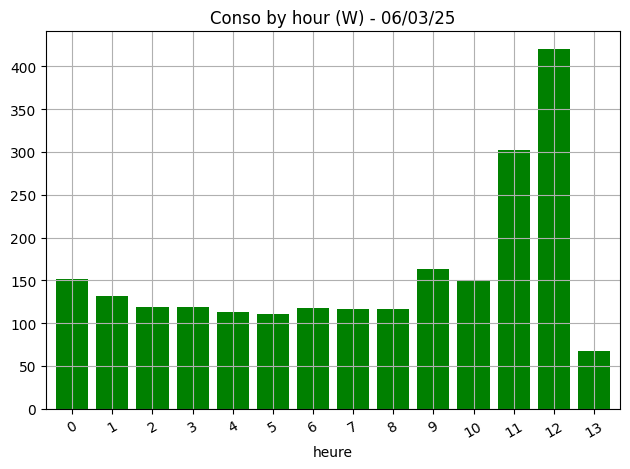

In [47]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [48]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 564 entries, 21/08/23 to 06/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     564 non-null    float64
dtypes: float64(1)
memory usage: 8.8+ KB


In [49]:
period()

2025-03-06 00:00:14.323627	2025-03-06 08:10:08.861627	8h 9m 54s 	1000


In [50]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time


heure
0     00:00:14.323627
0     00:00:40.544627
0     00:01:04.880627
0     00:01:29.147627
0     00:01:53.434627
           ...       
13    13:21:53.684627
13    13:22:20.049627
13    13:22:46.656627
13    13:23:13.791627
13    13:23:40.598627
Name: dates, Length: 2199, dtype: object

In [51]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
df_grp


,kWh
days,
21/08/23,0.535
22/08/23,3.691
23/08/23,4.238
24/08/23,3.687
25/08/23,3.925
...,...
02/03/25,3.483
03/03/25,3.989
04/03/25,3.329


In [52]:
df_grp.mean()


kWh    3.52159
dtype: float64

In [53]:
df_grp.head()


,kWh
days,
21/08/23,0.535
22/08/23,3.691
23/08/23,4.238
24/08/23,3.687
25/08/23,3.925


In [54]:
df_grp.tail()


,kWh
days,
02/03/25,3.483
03/03/25,3.989
04/03/25,3.329
05/03/25,3.844
06/03/25,2.199


# plot les 100 derniers jours


In [55]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.67757
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

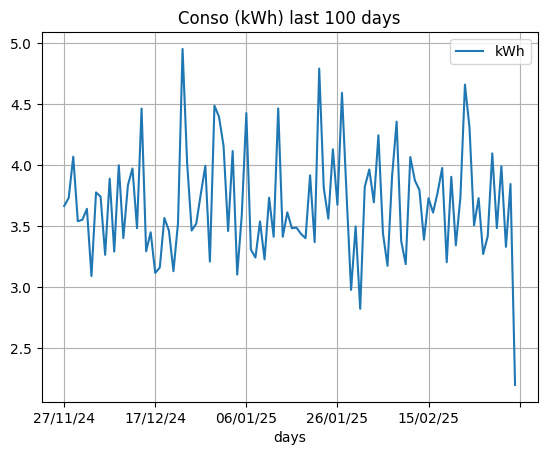

In [56]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [57]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.199
max,4.950


Text(0.5, 1.0, 'Last month conso by day')

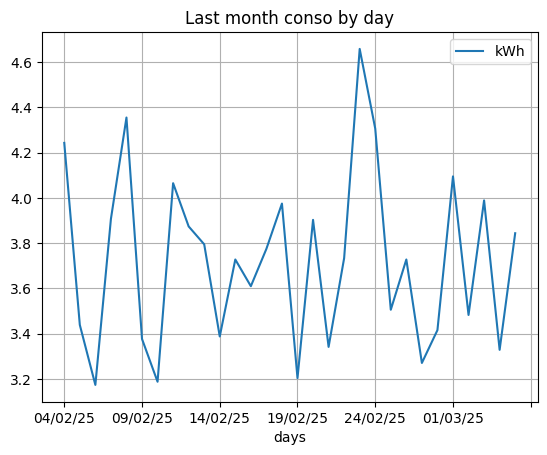

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.658
Min : 06/02/25 3.174


In [60]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-06 00:00:14.323627	2025-03-06 08:10:08.861627	8h 9m 54s 	1000
2025-03-06 08:10:08.861627	2025-03-06 12:27:34.120627	4h 17m 25s 	2000
2025-03-06 12:27:34.120627	2025-03-06 13:23:40.598627	0h 56m 6s 	199


('13:24:15', 2.199, 2199)

In [61]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 1983978 to 1986176
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2199 non-null   int64         
 1   kWh        2199 non-null   float64       
 2   sec        2199 non-null   float64       
 3   Wh         2199 non-null   float64       
 4   cumul(ms)  2199 non-null   int64         
 5   dates      2199 non-null   datetime64[ns]
 6   days       2199 non-null   object        
 7   heure      2199 non-null   object        
 8   hours      2199 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 171.8+ KB


In [62]:
conso_hours['heure'], conso_hours['hours']

(1983978     0
 1983979     0
 1983980     0
 1983981     0
 1983982     0
            ..
 1986172    13
 1986173    13
 1986174    13
 1986175    13
 1986176    13
 Name: heure, Length: 2199, dtype: object,
 1983978    00
 1983979    00
 1983980    00
 1983981    00
 1983982    00
            ..
 1986172    13
 1986173    13
 1986174    13
 1986175    13
 1986176    13
 Name: hours, Length: 2199, dtype: object)

In [63]:
# select number of days to display
span = 30
#df_grp.tail(span)


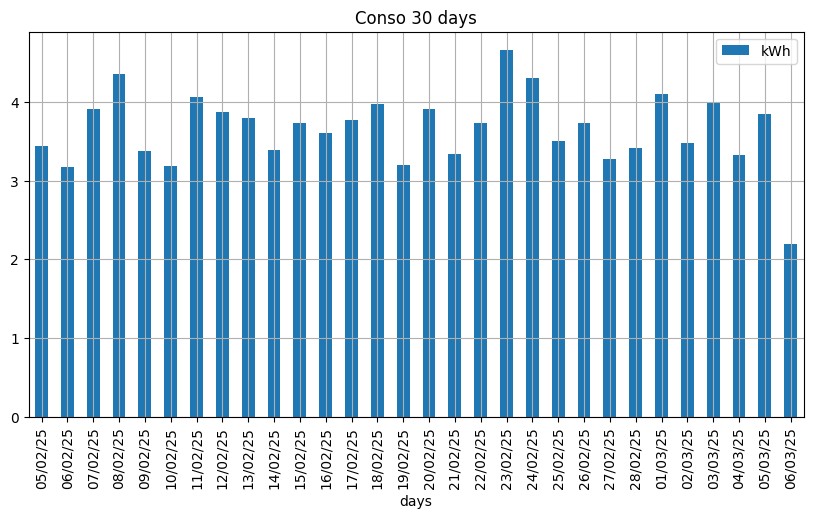

In [64]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


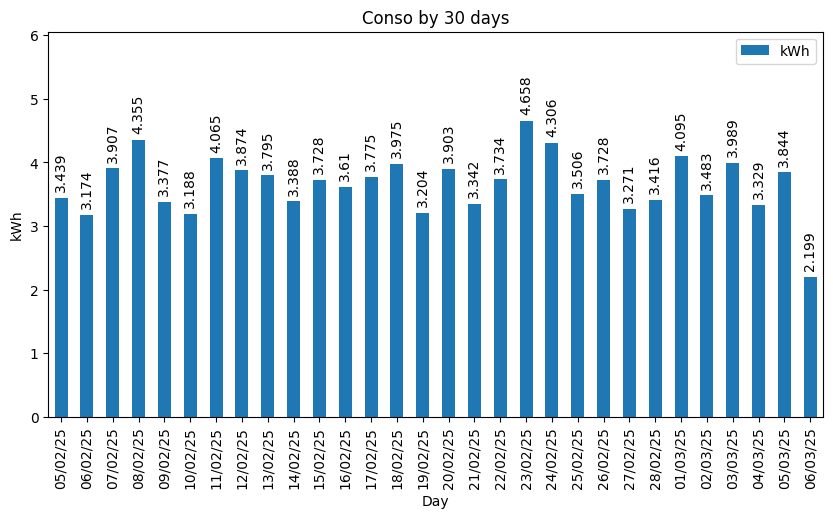

In [65]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [66]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
05/02/25    3.439
06/02/25    3.174
07/02/25    3.907
08/02/25    4.355
09/02/25    3.377
10/02/25    3.188
11/02/25    4.065
12/02/25    3.874
13/02/25    3.795
14/02/25    3.388
15/02/25    3.728
16/02/25    3.610
17/02/25    3.775
18/02/25    3.975
19/02/25    3.204
20/02/25    3.903
21/02/25    3.342
22/02/25    3.734
23/02/25    4.658
24/02/25    4.306
25/02/25    3.506
26/02/25    3.728
27/02/25    3.271
28/02/25    3.416
01/03/25    4.095
02/03/25    3.483
03/03/25    3.989
04/03/25    3.329
05/03/25    3.844
06/03/25    2.199
Name: kWh, dtype: float64

In [67]:
x_labels=df_grp.tail(span).index
x_labels

Index(['05/02/25', '06/02/25', '07/02/25', '08/02/25', '09/02/25', '10/02/25',
       '11/02/25', '12/02/25', '13/02/25', '14/02/25', '15/02/25', '16/02/25',
       '17/02/25', '18/02/25', '19/02/25', '20/02/25', '21/02/25', '22/02/25',
       '23/02/25', '24/02/25', '25/02/25', '26/02/25', '27/02/25', '28/02/25',
       '01/03/25', '02/03/25', '03/03/25', '04/03/25', '05/03/25', '06/03/25'],
      dtype='object', name='days')

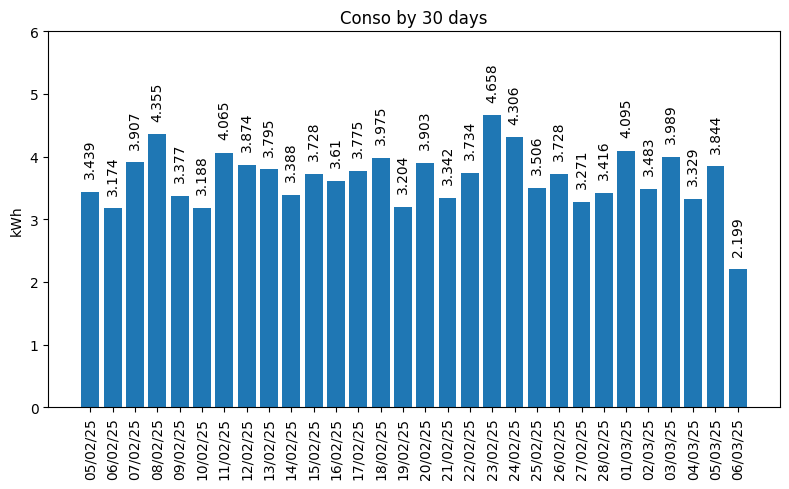

In [68]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [69]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

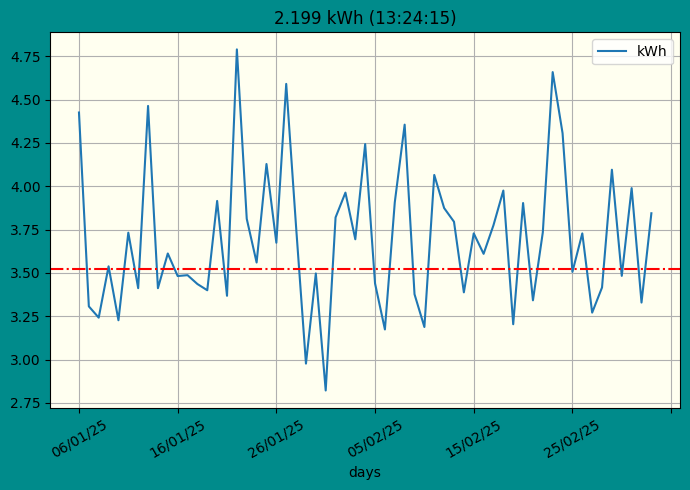

In [70]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

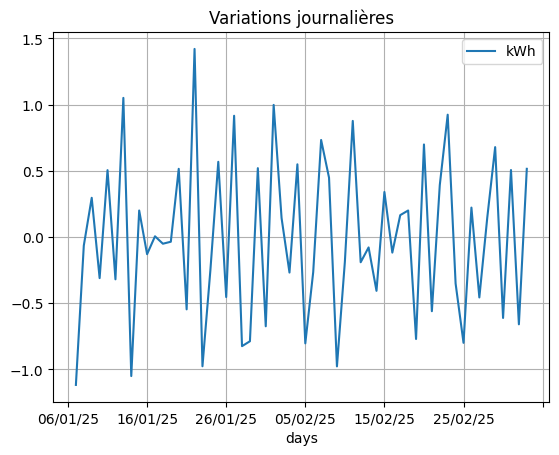

In [71]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

# Data from 21/08/23

In [72]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')


In [73]:
conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:26:33.603627,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:26:55.461627,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:27:17.462627,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:27:39.390627,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:28:01.281627,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
1986172,26288,0.14,26.288,136.944614,48614142015,2025-03-06 13:21:53.684627,06/03/25,13,2025-03,06
1986173,26365,0.14,26.365,136.544661,48614168380,2025-03-06 13:22:20.049627,06/03/25,13,2025-03,06
1986174,26607,0.14,26.607,135.302740,48614194987,2025-03-06 13:22:46.656627,06/03/25,13,2025-03,06
1986175,27135,0.13,27.135,132.669983,48614222122,2025-03-06 13:23:13.791627,06/03/25,13,2025-03,06


In [74]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)


In [75]:
conso_grouped_by_month.groups.keys()

dict_keys(['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

In [76]:
month=conso_grouped_by_month.get_group('2024-11')

In [77]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

In [78]:
conso_grouped_by_month_day.count()


,hours,months,kWh
day,,,
01,3291,3291,3291
02,4131,4131,4131
03,3069,3069,3069
04,4078,4078,4078
05,3088,3088,3088
06,3413,3413,3413
07,3515,3515,3515
08,3960,3960,3960
09,3312,3312,3312


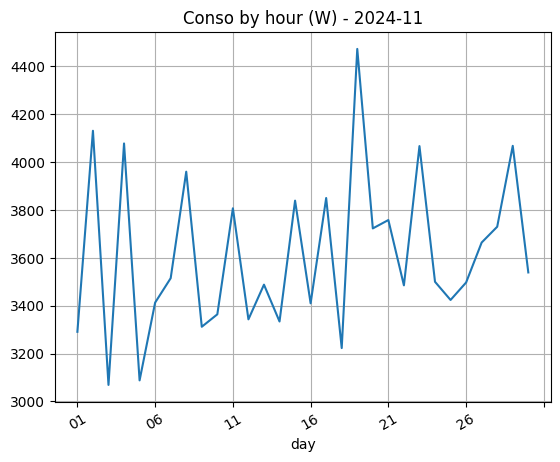

In [79]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [80]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [81]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3291,3291,3291
02,4131,4131,4131
03,3069,3069,3069
04,4078,4078,4078
05,3088,3088,3088
06,3413,3413,3413
07,3515,3515,3515
08,3960,3960,3960
09,3312,3312,3312


In [82]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [83]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [84]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2023-08,38467,38467,38467
2023-09,116300,116300,116300
2023-10,112874,112874,112874
2023-11,113598,113598,113598
2023-12,123314,123314,123314
2024-01,119511,119511,119511
2024-02,108749,108749,108749
2024-03,114283,114283,114283
2024-04,109917,109917,109917


In [85]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [86]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [87]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,535
22/08/23,3691
23/08/23,4238
24/08/23,3687
25/08/23,3925
...,...
02/03/25,3483
03/03/25,3989
04/03/25,3329


In [88]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:26:33.603627,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:26:55.461627,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:27:17.462627,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:27:39.390627,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:28:01.281627,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
1986172,26288,0.14,26.288,136.944614,48614142015,2025-03-06 13:21:53.684627,06/03/25,13,2025-03,06
1986173,26365,0.14,26.365,136.544661,48614168380,2025-03-06 13:22:20.049627,06/03/25,13,2025-03,06
1986174,26607,0.14,26.607,135.302740,48614194987,2025-03-06 13:22:46.656627,06/03/25,13,2025-03,06
1986175,27135,0.13,27.135,132.669983,48614222122,2025-03-06 13:23:13.791627,06/03/25,13,2025-03,06


In [89]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
06/03/25 13    1986172  06/03/25    13  0.14
               1986173  06/03/25    13  0.14
               1986174  06/03/25    13  0.14
               1986175  06/03/25    13  0.13
               1986176  06/03/25    13  0.13

[1986177 rows x 3 columns]

In [90]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [91]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [92]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,535,535
22/08/23,3691,3691
23/08/23,4238,4238
24/08/23,3687,3687
25/08/23,3925,3925
...,...,...
02/03/25,3483,3483
03/03/25,3989,3989
04/03/25,3329,3329


In [93]:
grp_by_day['kWh'].cumsum()

days
21/08/23        535
22/08/23       4226
23/08/23       8464
24/08/23      12151
25/08/23      16076
             ...   
02/03/25    1972816
03/03/25    1976805
04/03/25    1980134
05/03/25    1983978
06/03/25    1986177
Name: kWh, Length: 564, dtype: int64

In [94]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21     105
         22     282
         23     148
22/08/23 00     129
         01     131
...             ...
06/03/25 09     163
         10     149
         11     302
         12     420
         13      67

[13505 rows x 1 columns]

In [95]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21           105
          22           387
          23           535
22/08/23  00           664
          01           795
                    ...   
06/03/25  09       1985239
          10       1985388
          11       1985690
          12       1986110
          13       1986177
Name: kWh, Length: 13505, dtype: int64

In [96]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21     105     105    NaN
         22     282     387  177.0
         23     148     535 -134.0
22/08/23 00     129     129    NaN
         01     131     260    2.0
...             ...     ...    ...
06/03/25 09     163    1261   46.0
         10     149    1410  -14.0
         11     302    1712  153.0
         12     420    2132  118.0
         13      67    2199 -353.0

[13505 rows x 3 columns]

In [97]:
today, grp_by_dayhours.loc[today]

('06/03/25',
        kWh  cumsum   diff
 hours                    
 00     152     152    NaN
 01     132     284  -20.0
 02     119     403  -13.0
 03     119     522    0.0
 04     113     635   -6.0
 05     111     746   -2.0
 06     118     864    7.0
 07     117     981   -1.0
 08     117    1098    0.0
 09     163    1261   46.0
 10     149    1410  -14.0
 11     302    1712  153.0
 12     420    2132  118.0
 13      67    2199 -353.0)

Text(0.5, 1.0, 'Cumul journalier')

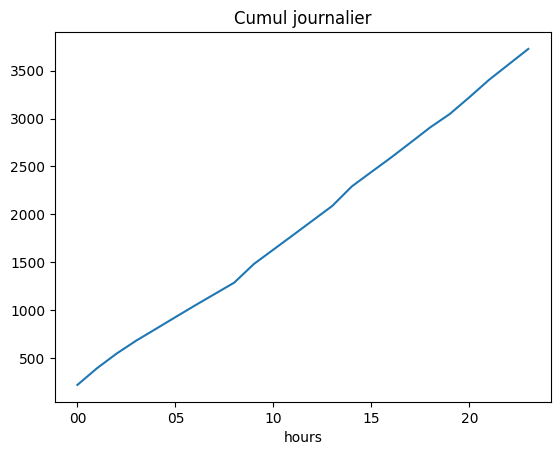

In [98]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

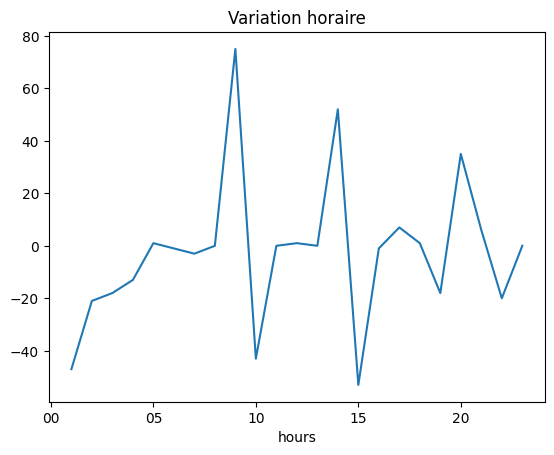

In [99]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [100]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

564

In [101]:
df_grp.tail(n)['kWh'].describe()


count    564.000000
mean       3.521590
std        0.665171
min        0.535000
25%        3.347250
50%        3.629500
75%        3.890000
max        4.994000
Name: kWh, dtype: float64

In [102]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '564 days')

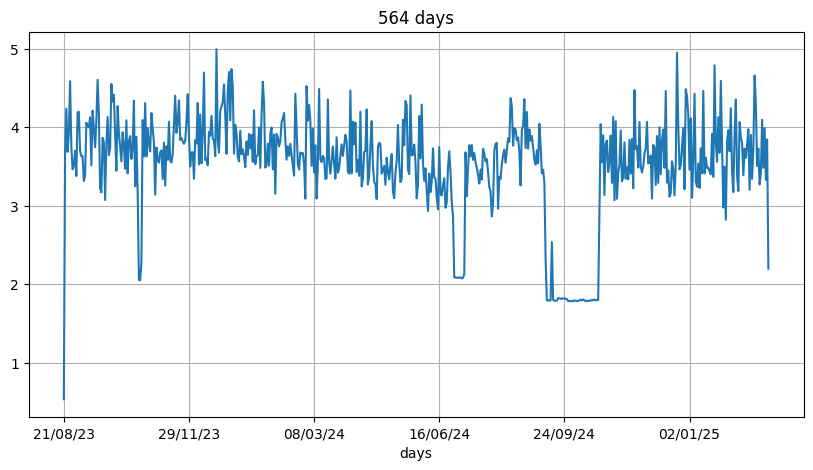

In [103]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

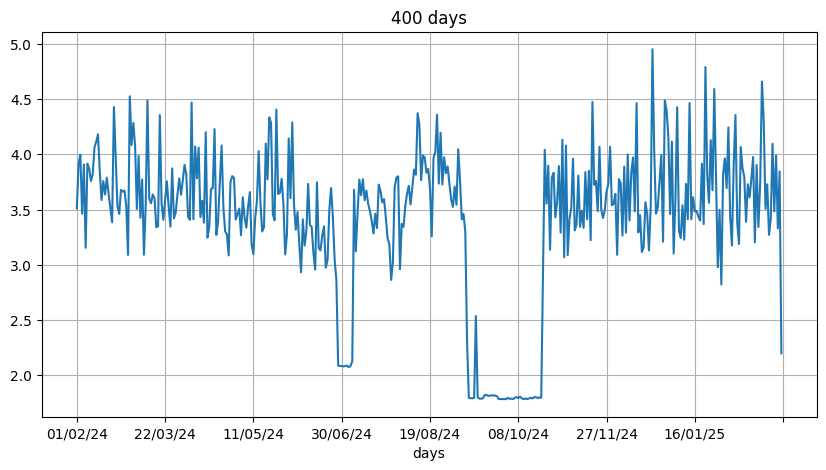

In [104]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [105]:
df_grp['kWh']

days
21/08/23    0.535
22/08/23    3.691
23/08/23    4.238
24/08/23    3.687
25/08/23    3.925
            ...  
02/03/25    3.483
03/03/25    3.989
04/03/25    3.329
05/03/25    3.844
06/03/25    2.199
Name: kWh, Length: 564, dtype: float64

In [106]:
df_grp.describe()

,kWh
count,564.000000
mean,3.521590
std,0.665171
min,0.535000
25%,3.347250
50%,3.629500
75%,3.890000
max,4.994000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

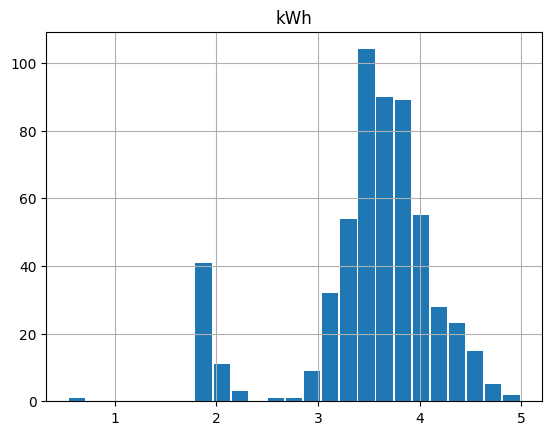

In [107]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [108]:
df_grp.tail(span)['kWh']

days
01/02/24    3.510
02/02/24    3.913
03/02/24    3.996
04/02/24    3.463
05/02/24    3.907
            ...  
02/03/25    3.483
03/03/25    3.989
04/03/25    3.329
05/03/25    3.844
06/03/25    2.199
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [109]:
day

'06/03/25'

In [110]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,152,152,NaN
01,132,284,-20.0
02,119,403,-13.0
03,119,522,0.0
04,113,635,-6.0
05,111,746,-2.0
06,118,864,7.0
07,117,981,-1.0
08,117,1098,0.0


In [111]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


14

In [112]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 15)

In [113]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [114]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [115]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
Name: days, dtype: float64

In [116]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [117]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 00 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     14 non-null     int64  
 1   cumsum  14 non-null     int64  
 2   diff    13 non-null     float64
 3   days    14 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 560.0+ bytes


In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
Name: days, dtype: float64

In [119]:
day

'06/03/25'

In [120]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,152,152,NaN,1.0
01,132,284,-20.0,2.0
02,119,403,-13.0,3.0
03,119,522,0.0,4.0
04,113,635,-6.0,5.0
05,111,746,-2.0,6.0
06,118,864,7.0,7.0
07,117,981,-1.0,8.0
08,117,1098,0.0,9.0


Text(0.5, 1.0, '06/03/25')

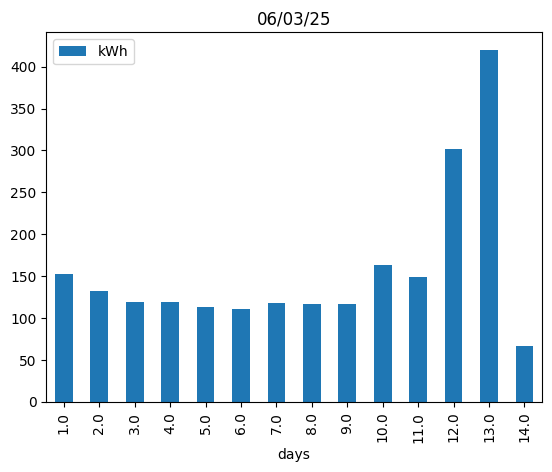

In [121]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [122]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13'],
      dtype='object', name='hours')

# Conso du jour


In [123]:

grp_by_dayhours.count()

kWh       13505
cumsum    13505
diff      12941
days         14
dtype: int64

In [124]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    151
01    165
02    164
03    154
04    169
05    149
06    165
07    147
08    115
09    130
10    120
11    125
12    131
13    114
14    130
15    200
16    142
17    154
18    957
19    208
20    285
21    302
22    308
23    309
Name: kWh, dtype: int64

In [125]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

367.757

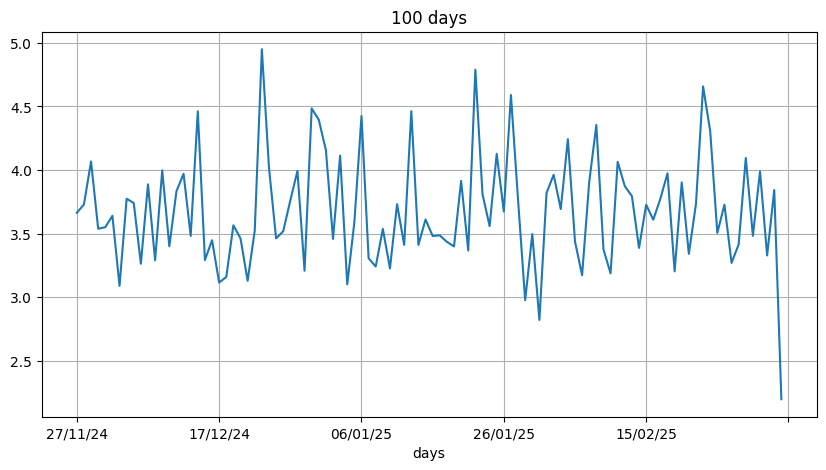

In [126]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [127]:
df_grp.tail(1)

,kWh
days,
06/03/25,2.199


In [128]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

2.199

In [129]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

159.07730793952942


# Today

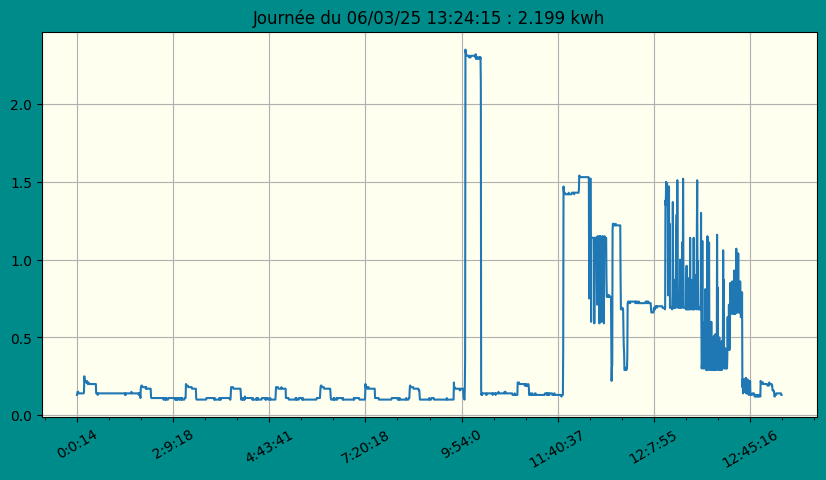

In [130]:
show(today,bgcolor='ivory')

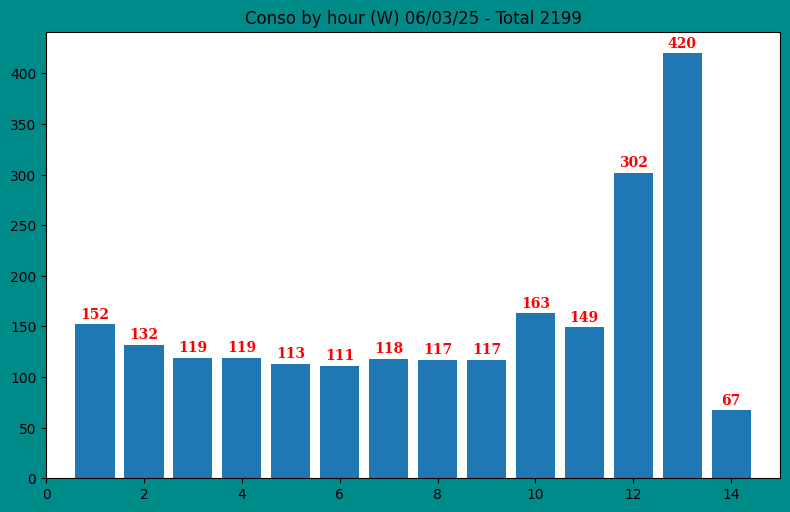

In [131]:
conso_by_hour(today)

In [132]:
day = '23/02/25'

('23/02/25', None)

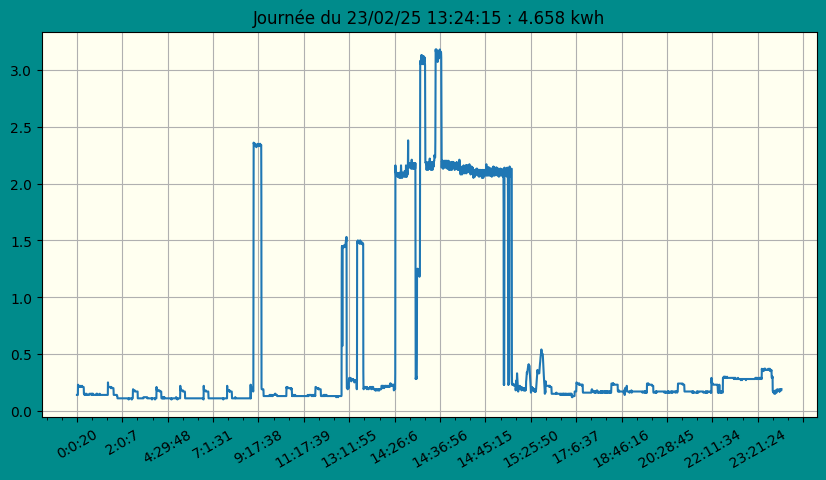

In [133]:
day, show(day,bgcolor='ivory')

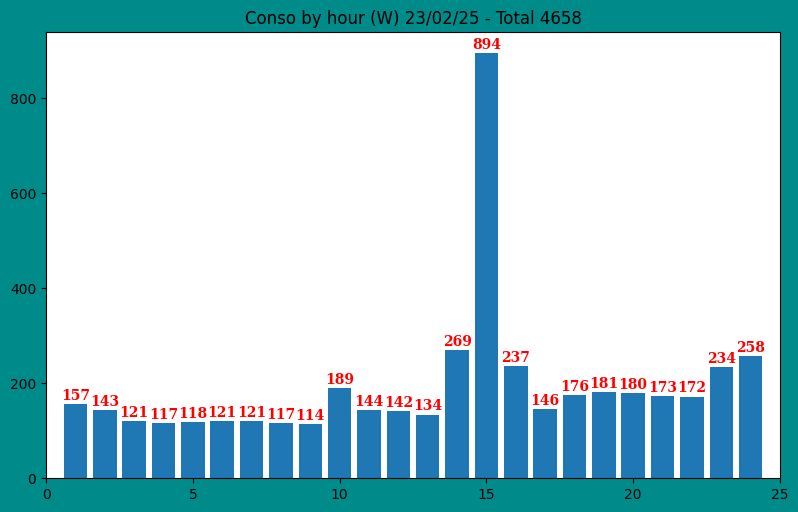

In [134]:
conso_by_hour(day)

In [135]:
maxday

'21/12/23'

('21/12/23', None)

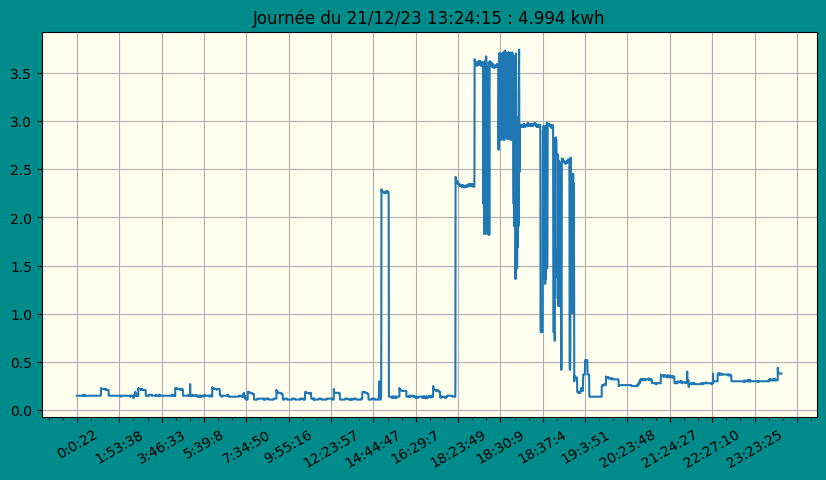

In [136]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

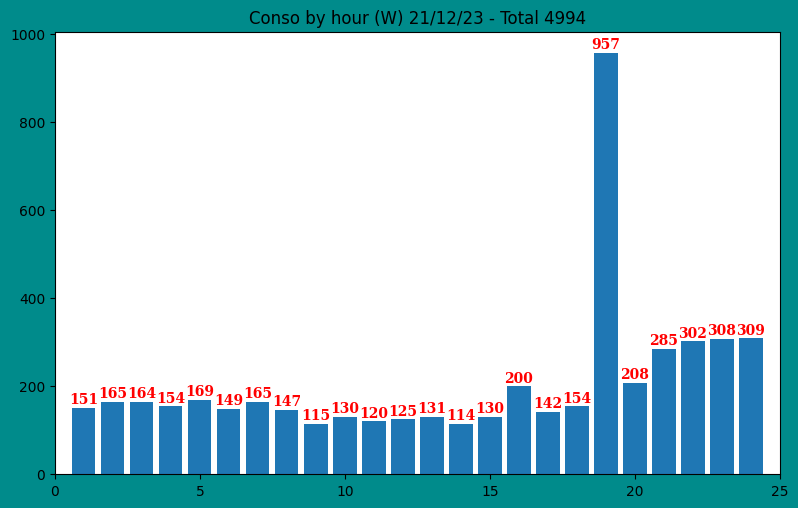

In [137]:
conso_by_hour(day)

In [138]:
sum(data)

4994

In [139]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,152,152,NaN,1.0
01,132,284,-20.0,2.0
02,119,403,-13.0,3.0
03,119,522,0.0,4.0
04,113,635,-6.0,5.0
05,111,746,-2.0,6.0
06,118,864,7.0,7.0
07,117,981,-1.0,8.0
08,117,1098,0.0,9.0


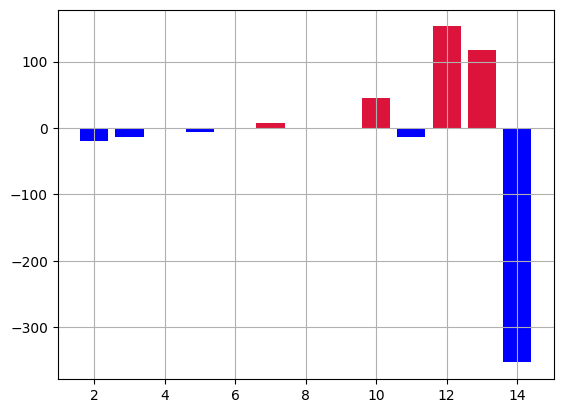

In [140]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [141]:
data

hours
00    151
01    165
02    164
03    154
04    169
05    149
06    165
07    147
08    115
09    130
10    120
11    125
12    131
13    114
14    130
15    200
16    142
17    154
18    957
19    208
20    285
21    302
22    308
23    309
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

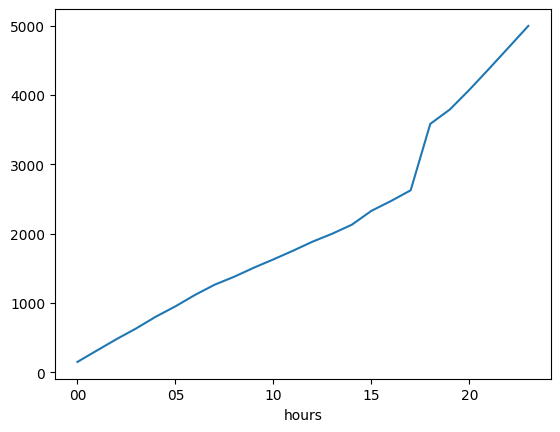

In [142]:
data.cumsum().plot()


<Axes: xlabel='hours'>

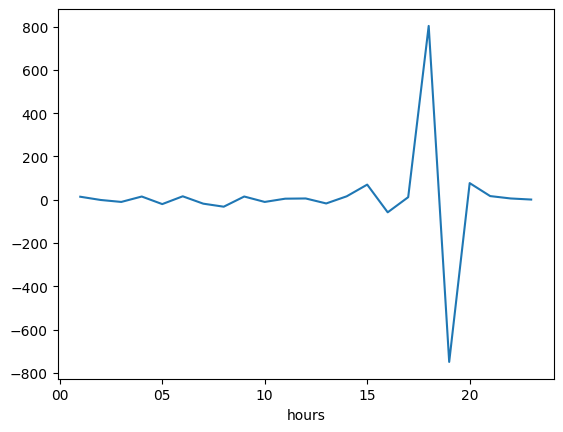

In [143]:
# evolution par heure
data.diff().plot()

In [144]:
data.diff().describe()

count     23.000000
mean       6.869565
std      235.762266
min     -749.000000
25%      -13.500000
50%        6.000000
75%       15.500000
max      803.000000
Name: kWh, dtype: float64

<Axes: >

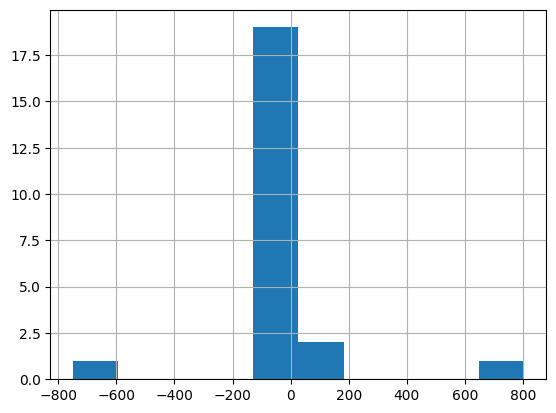

In [145]:
data.diff().hist()

# Test sauvegarde

In [146]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [147]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [148]:
#conso_byhour(day)

In [149]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


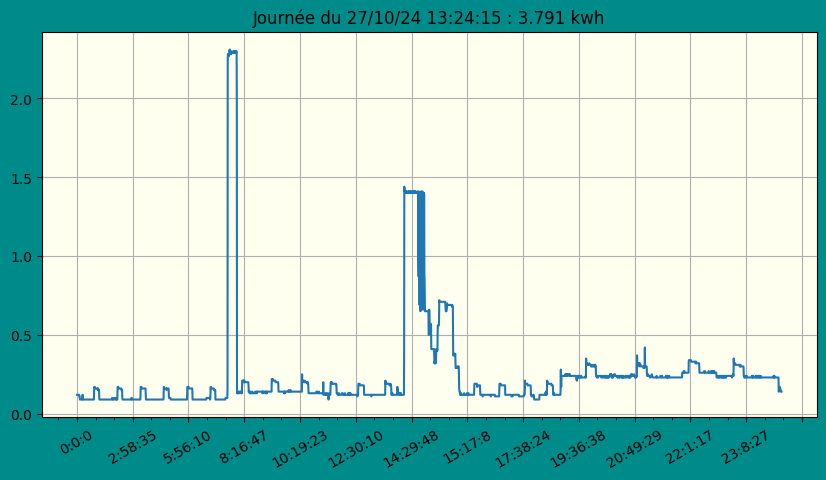

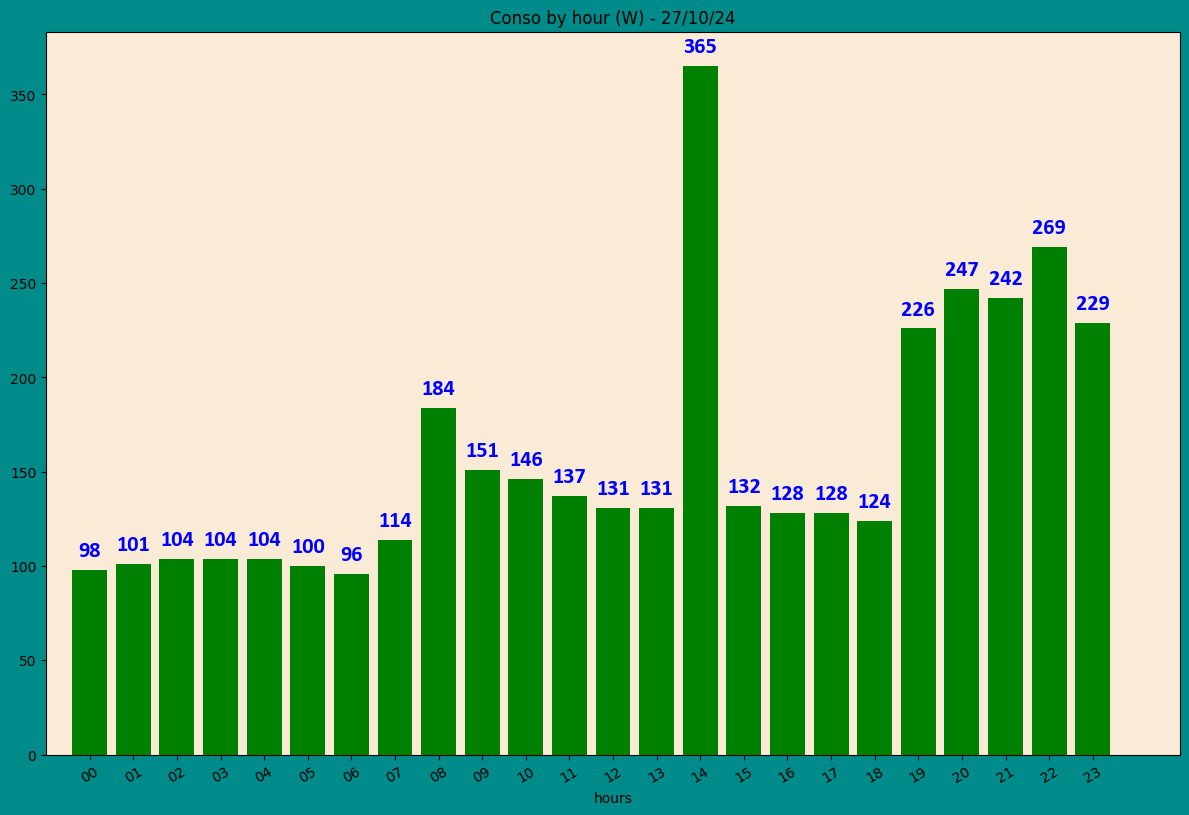

In [150]:
day = '27/10/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [151]:
month.describe()


,kWh
count,108443.000000
mean,0.334554
std,0.564592
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.730000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

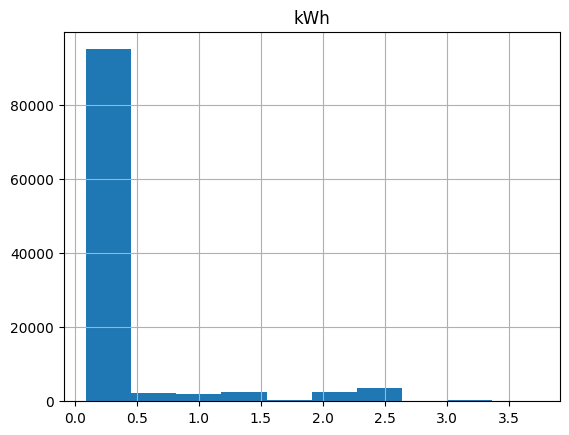

In [152]:
month.hist()

<Axes: >

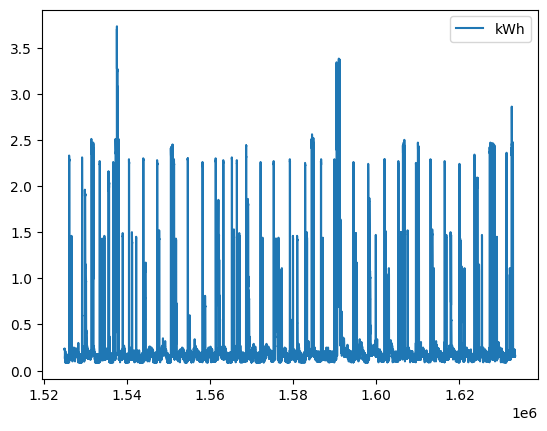

In [153]:
month.plot()

In [154]:
# index with max conso in this month
month.idxmax().kWh

1537642

In [155]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

day       1629882
hours     1528098
months    1524978
kWh       1537642
dtype: int64

In [156]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [157]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21     105     105    NaN   NaN
         22     282     387  177.0   NaN
         23     148     535 -134.0   NaN
22/08/23 00     129     129    NaN   NaN
         01     131     260    2.0   NaN
...             ...     ...    ...   ...
06/03/25 09     163    1261   46.0  10.0
         10     149    1410  -14.0  11.0
         11     302    1712  153.0  12.0
         12     420    2132  118.0  13.0
         13      67    2199 -353.0  14.0

[13505 rows x 4 columns]

In [158]:
month

,day,hours,months,kWh
1524978,01,00,2024-11,0.23
1524979,01,00,2024-11,0.23
1524980,01,00,2024-11,0.23
1524981,01,00,2024-11,0.23
1524982,01,00,2024-11,0.23
...,...,...,...,...
1633416,30,23,2024-11,0.16
1633417,30,23,2024-11,0.16
1633418,30,23,2024-11,0.16
1633419,30,23,2024-11,0.16


In [159]:
month.idxmax()


day       1629882
hours     1528098
months    1524978
kWh       1537642
dtype: int64

In [160]:
month.loc[month.idxmax().kWh]


day            04
hours          13
months    2024-11
kWh          3.73
Name: 1537642, dtype: object

In [161]:
grp_by_dayhours.loc[['28/02/25']].idxmax()

C:\Users\jean\AppData\Local\Temp\ipykernel_4452\4095454801.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  grp_by_dayhours.loc[['28/02/25']].idxmax()


kWh       (28/02/25, 20)
cumsum    (28/02/25, 23)
diff      (28/02/25, 08)
days                 NaN
dtype: object

In [162]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [163]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [164]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [165]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB